# ANNDL: 1st challenge


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [24]:
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

seed = 42
input_img_size = 96

np.random.seed(seed)
tf.random.set_seed(seed)

## ⏳ Load the Data

The data are loaded from the filtered, pre-processed data. For more details, see '''Preprocessing.ipynb''' notebook.

In [25]:
filtered_dataset_path = '../Preprocessing/balanced_dataset.npz'
data = np.load(filtered_dataset_path)
X = data['images']
y = data['labels']

# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Show the shape of the dataset
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (18640, 96, 96, 3)
y shape: (18640,)


##  🦠 Process the Data


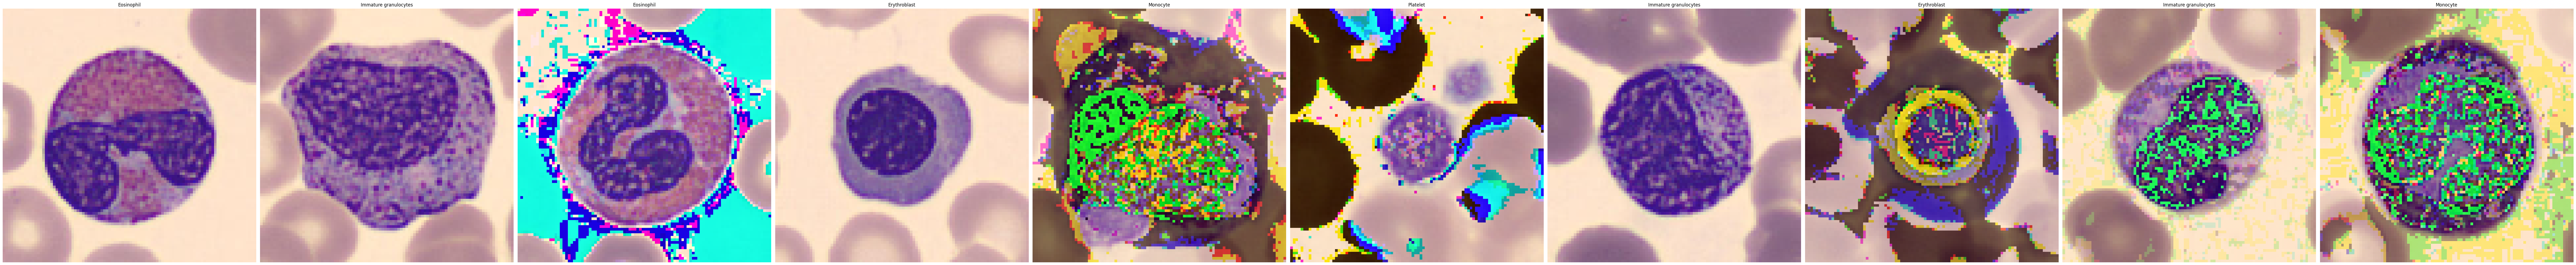

In [26]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(labels[y[idx]])
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [27]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
7    2330
3    2330
6    2330
2    2330
1    2330
5    2330
0    2330
4    2330
Name: count, dtype: int64


In [28]:
# Normalize the data to the range [0, 1] and encode output labels
X = (X / 255).astype('float32')
y = tfk.utils.to_categorical(y, num_classes=len(unique_labels))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=np.argmax(y, axis=1))
print(f'Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}, Validation labels shape: {y_val.shape}')

Training data shape: (14912, 96, 96, 3), Validation data shape: (3728, 96, 96, 3)
Training labels shape: (14912, 8), Validation labels shape: (3728, 8)


## 🔆 Augmenting the training and validation set
We use AutoContrast and RandomSaturation from the keras library for the training set. It enhances contrast adaptively and may help in highlighting subtle differences between cell types without altering structure. 
We added the augmented images to the training set & we applied some rotation, zoom and shift.

We use RandAugment for the validation set. 

In [29]:
# Import keras
import keras_cv as kcv

In [30]:
# Due to the RAM constraint, I perform some static data augmentation
# only on a portion of the training set
X_train_to_augment = X_train[:int(0.4 * len(X_train))]
y_train_to_augment = y_train[:int(0.4 * len(y_train))]

print(f'Training data to augment shape: {X_train_to_augment.shape}')

Training data to augment shape: (5964, 96, 96, 3)


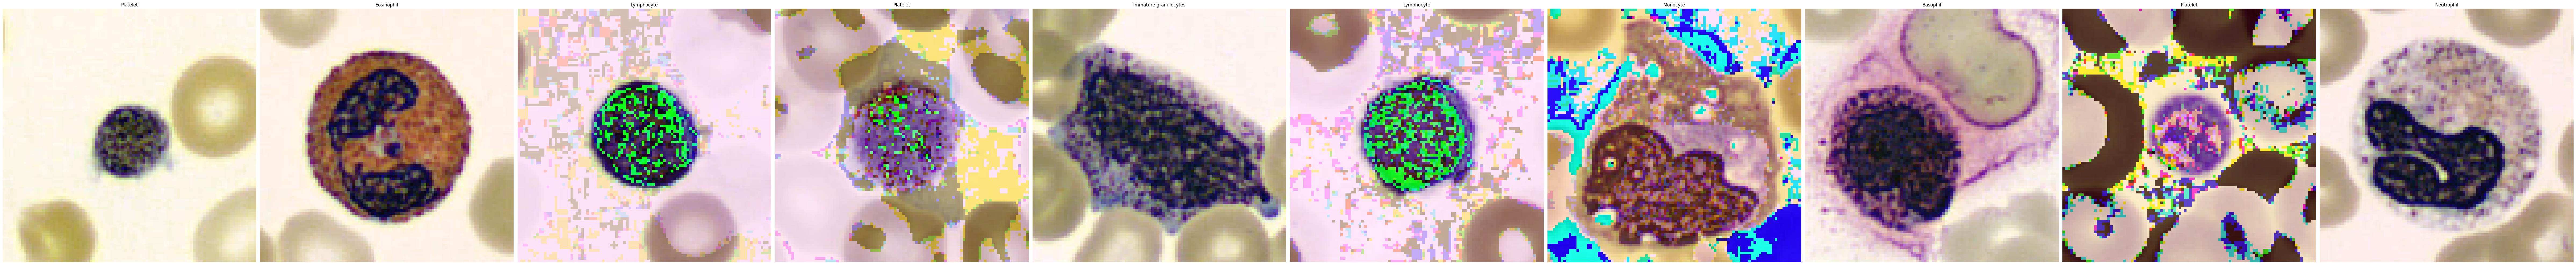

In [31]:
# Implement AutoContrast
value_range = [0, 1]
autocontrast = kcv.layers.AutoContrast(value_range)
contrast_result = autocontrast({'images': X_train_to_augment, 'labels': y_train_to_augment})

# Show some images
num_img = 10
random_indices = random.sample(range(len(contrast_result["images"])), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(contrast_result["images"][idx]), vmin=0., vmax=1.)
    # Get the index of the maximum value (representing the predicted class)
    label_index = np.argmax(contrast_result["labels"][idx])
    ax.set_title(labels[label_index])
    ax.axis('off')

plt.tight_layout()
plt.show()

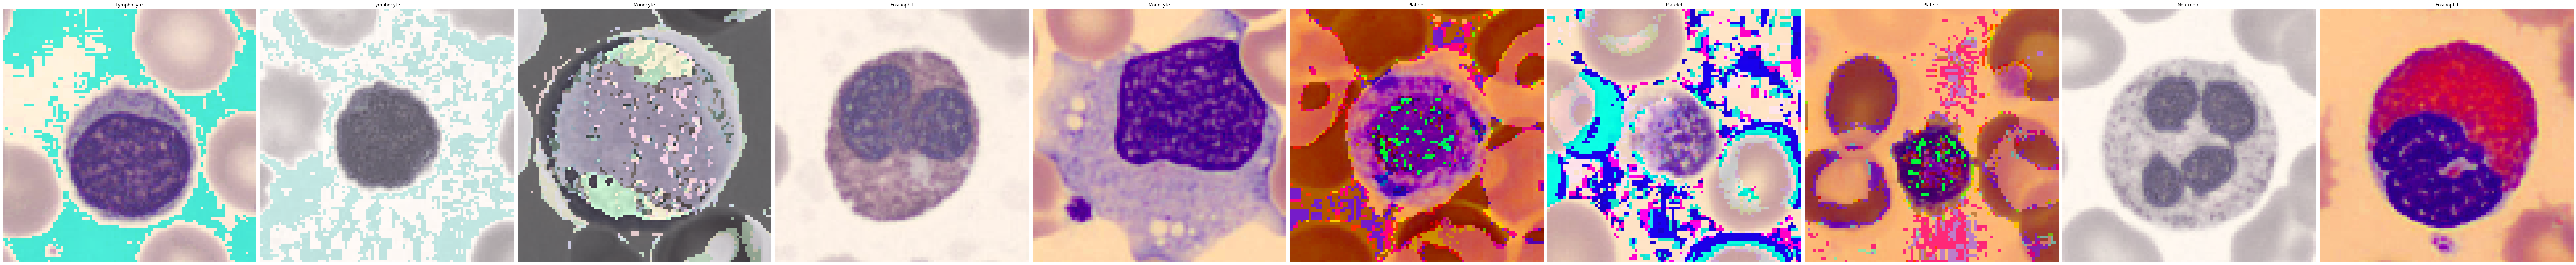

In [32]:
# Implement RandomSaturation
factor = [0, 1]
randomsaturation = kcv.layers.RandomSaturation(factor, seed=seed)
saturation_result = randomsaturation({'images': X_train_to_augment, 'labels': y_train_to_augment})

# Show some images
num_img = 10
random_indices = random.sample(range(len(saturation_result["images"])), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(saturation_result["images"][idx]), vmin=0., vmax=1.)
    # Get the index of the maximum value (representing the predicted class)
    label_index = np.argmax(saturation_result["labels"][idx])
    ax.set_title(labels[label_index])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [33]:
# Add the result of the augmentatation to the original training set
X_train = np.concatenate((X_train, contrast_result["images"]), axis=0)
y_train = np.concatenate((y_train, contrast_result["labels"]), axis=0)
X_train = np.concatenate((X_train, saturation_result["images"]), axis=0)
y_train = np.concatenate((y_train, saturation_result["labels"]), axis=0)

# Inspect the target
print('Counting occurrences of target classes:')
y_train_indices = np.argmax(y_train, axis=1) 
print(pd.DataFrame(y_train_indices, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
2    3400
1    3380
6    3366
0    3364
5    3352
3    3346
7    3330
4    3302
Name: count, dtype: int64


In [34]:
# Augmenting validation set
randaugment = kcv.layers.RandAugment(value_range=(0, 1), augmentations_per_image=3, magnitude=0.2)
X_val = randaugment(X_val)
print("X_val (augmented) shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_val (augmented) shape: (3728, 96, 96, 3)
y_val shape: (3728, 8)


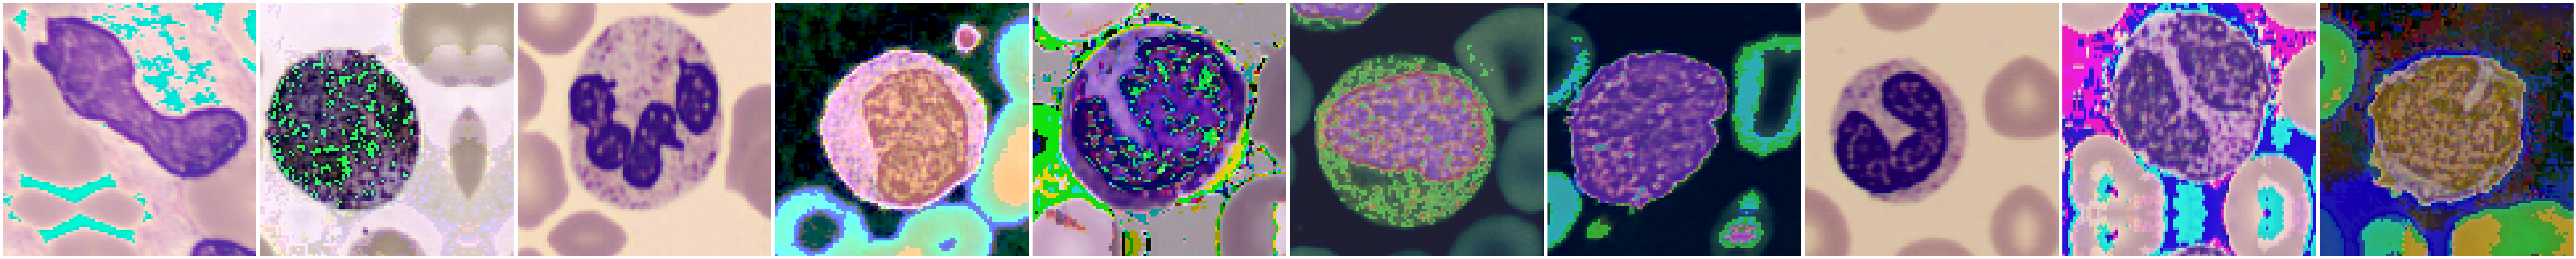

In [35]:
# Show some images
num_img = 10
random_indices = random.sample(range(len(X_val)), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_val[idx]), vmin=0., vmax=1.)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 🛠️ Train and Save the Model

The next sequence of cells performs Transfer Learning on a 

In [36]:
# Define hyperparameters
epochs = 20
batch_size = 32
learning_rate = 0.001

# Retrieve input and output shape
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

In [38]:
# Initialise densenet model with pretrained weights, for transfer learning
transfer_layer = tfk.applications.DenseNet121 (
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    # include_preprocessing=True,
    classifier_activation='softmax'
)

# Freeze all layers in TL model to use it solely as a feature extractor
transfer_layer.trainable = False

# Display a summary of the model architecture
# transfer_layer.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(dense, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)


In [39]:
# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape)

# Define a layer of dynamic data augmentation
augmentation = tfk.Sequential([
    # Positional augmentations
    tfk.layers.RandomFlip("horizontal_and_vertical"),
    tfk.layers.RandomRotation(0.35),
    tfk.layers.RandomZoom(0.3),
    tfk.layers.RandomTranslation(0.35, 0.35),
    # Color augmentations
    tfk.layers.RandomContrast(0.2),
    tfk.layers.RandomBrightness(0.15),
    # Other augmentations
    kcv.layers.RandomCutout(0.2, 0.2)
], name='augmentation')(inputs)
# TODO: aggiungere cutmix, mixup, channel shuffle

# Pass inputs through the feature extractor
x = transfer_layer(augmentation)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.5, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(), 
    optimizer=tfk.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
)

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_flip_2 (RandomFlip) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_rotation_2          │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_zoom_2 (RandomZoom) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_translation_6       │ (None, 96, 96, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_contrast_4          │ (None, 96, 96, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_brightness_4        │ (None, 96, 96, 3)      │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_cutout_2            │ (None, 96, 96, 3)      │             0 │
│ (RandomCutout)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_6 (InputLayer) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ zero_padding2d             │ (None, 102, 102, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_conv (Conv2D)        │ (None, 48, 48, 64)     │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_bn                   │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1_relu (Activation)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ zero_padding2d_1           │ (None, 50, 50, 64)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ pool1 (MaxPooling2D)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_0_bn          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_0_relu        │ (None, 24, 24, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2_block1_1_conv        │ (None, 24, 24, 128)    │         8,19

 Total params: 7,045,704 (26.88 MB)

 Trainable params: 8,200 (32.03 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [40]:
# Define the callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=10, 
    restore_best_weights=True
)

# Define the learning rate reduction on plateau
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train * 255),
    y = y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(preprocess_input(X_val * 255), y_val),
    callbacks=callbacks
).history

In [ ]:
# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the model weights
tl_model.save('tl_model.keras')

# Free memory by deleting the model instance
del tl_model

## Fine Tuning
...



In [ ]:
# Load the previous model
ft_model = tfk.models.load_model('tl_model.keras')
ft_model.summary()

In [ ]:
# Set all MobileNetV3Small layers as trainable
ft_model.get_layer('MobileNetV3Small').trainable = True

for i, layer in enumerate(ft_model.get_layer('MobileNetV3Small').layers):
   # Following the suggestion of prof. Lomurno, we freeze the BatchNormalization layers
   if isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = False
   print(i, layer.name, layer.trainable)

In [ ]:
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Freeze first N layers and leave the rest trainable
N = 35
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Small').layers[:N]):
  layer.trainable=False

tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

for i, layer in enumerate(ft_model.get_layer('MobileNetV3Small').layers):
  print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model with a lower learning rate to perform fine-tuning
ft_model.compile (
    loss=tfk.losses.CategoricalCrossentropy(), 
    optimizer=tfk.optimizers.Adam(1e-5), 
    metrics=['accuracy']
)

In [ ]:
# Define the callbacks
early_stopping_ft = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=10, 
    restore_best_weights=True
)

# Define the learning rate reduction on plateau
reduce_lr_ft = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks_ft = [early_stopping_ft, reduce_lr_ft]

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train * 255),
    y = y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(preprocess_input(X_val * 255), y_val),
    callbacks=callbacks
).history

In [ ]:
# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(ft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'ft_weights.keras'
ft_model.save(model_filename)

# Free memory by deleting the model instance
del ft_model

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()
     

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```


In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('ft_weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = (X / 255.0)
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
# Create the .zip file to be submitted
import os
import zipfile

# Check if model.py and weights.keras exist
if os.path.exists("model.py") and os.path.exists("ft_weights.keras"):
    # Create a ZIP file containing model.py and weights.keras
    with zipfile.ZipFile("sub.zip", "w") as model_zip:
        model_zip.write("model.py")
        model_zip.write("ft_weights.keras")
    print("model.zip has been created successfully.")
else:
    print("model.py or weights.keras not found. Please ensure both files are in the current directory.")